<a href="https://colab.research.google.com/github/Leandro-Braga/Estudo_de_Caso/blob/main/Atividade_ARIMA_Leandeo_Braga_Vendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Comando para Reiniciar o KERNEL do Colab

In [1]:
# condacolab KERNEL RESTART
print("🔁 Restarting kernel...")
get_ipython().kernel.do_shutdown(True)

🔁 Restarting kernel...


{'restart': True, 'status': 'ok'}

### Tema: Projeto Modelagem ARIMA 

O estudo da modelagem autorregressiva integráveis de médias móveis ARIMA, de larga utilização na modelagem de séries estacionárias e não estacionárias integradas, é essencial para o profissional na análise de séries temporais financeiras, econômicas, logísticas, de negócios, gestão, entre outras, pois apresentam características distintas como valores defasados e que ocorrem contemporaneamente e em vários momentos no passado.

**Importação das bibliotecas necessárias**

In [1]:
# biblioteca de análise básica
import pandas as pd
import numpy as np
import seaborn as sns

# biblioteca de modelagem e testes
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


# bibliotecas de visualização
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import plotly.offline as py
import plotly.graph_objs as go

# ignorando avisos
import warnings
warnings.filterwarnings('ignore')

# Configuração de tamanho, cor e texto
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 16, 6
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'G'

print('\033[34mBibliotecas importadas!\033[m')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Bibliotecas importadas!


In [2]:
# Abri uma janela para carregar o arquivo

from google.colab import files
upload = files.upload()

Saving dados_valor.csv to dados_valor.csv


In [3]:
df = pd.read_csv('dados_valor.csv')

In [4]:
df.head(100)

,Dia,Valor
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
95,1999-06-01,8.165323
96,1999-07-01,8.717420
97,1999-08-01,9.070964
98,1999-09-01,9.177113


In [5]:
# Visualizar informação do DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dia     204 non-null    object 
 1   Valor   204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


Antes de fazer a decomposição da série, temos que transformar a data em índice:

In [6]:
# Transformando a data em índice

df.Dia = pd.to_datetime(df.Dia)
df.set_index('Dia', inplace=True)

In [7]:
# Verificando o índice
df.head()

,Valor
Dia,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [8]:
# Exibir gráfico de distribuição da série temporal

grafico = [go.Scatter(x=df.index, y=df['Valor'])]
py.iplot(grafico)

#### Identificação

A primeira coisa é verificar a estacionariedade nos dados. A estacionaridade será verificada pelo Teste Dicky Fuller Aumentado. A hipótese nula para este teste é que a Série Temporal é não Estacionária. Assim, se o valor de p for menor que 0,05, rejeitaremos a hipótese nula e acreditaremos que a série é Estacionária.

In [9]:
result = adfuller(df.Valor.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.145186
p-value: 1.000000


O valor de p obtido é superior ao nível de significância de 0,05. Claramente, não há razão para rejeitar a hipótese nula. Então, a série temporal é de fato não estacionária.

O resultado acima seria estacionario desde que f < 1, caso em que o termo f aproxima-se de zero. Desse modo, confirmando a estacionariedade do modelo.

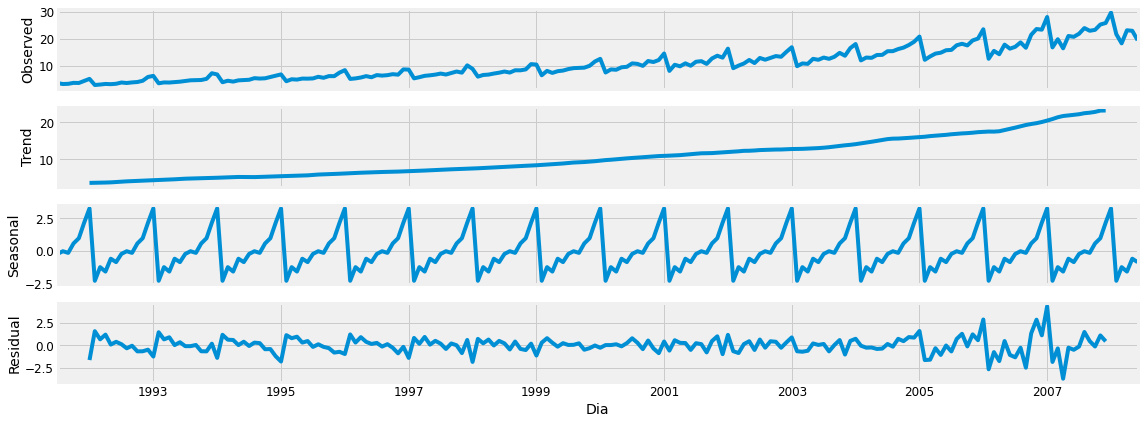

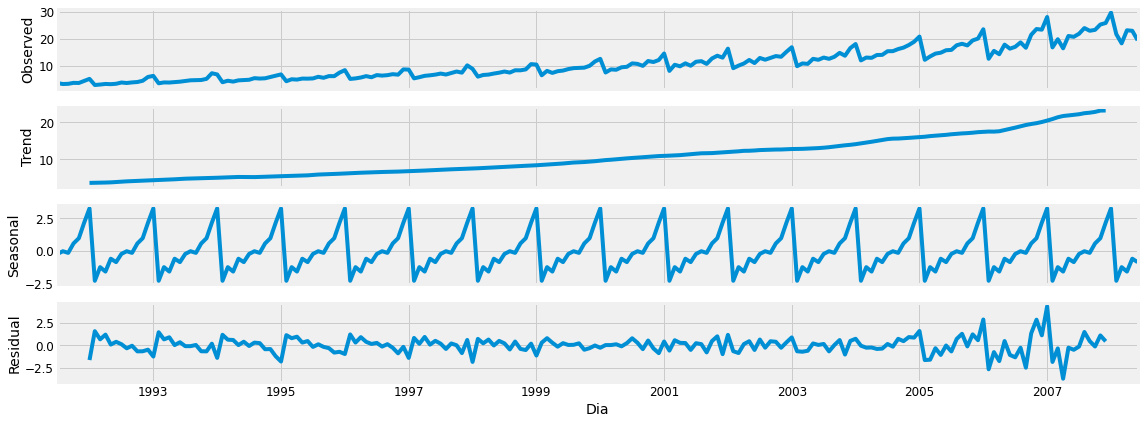

In [10]:
# Salvando a decomposição no modelo aditivo

rcParams['figure.figsize'] = 16, 6

resultado = seasonal_decompose(df, model='additive')
resultado.plot()

Vamos aplicar a decomposição multiplicativa à série:

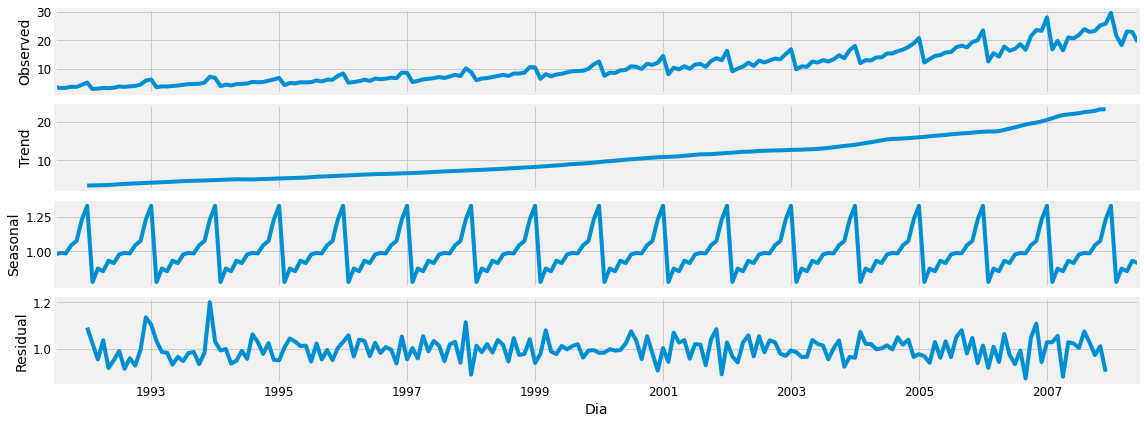

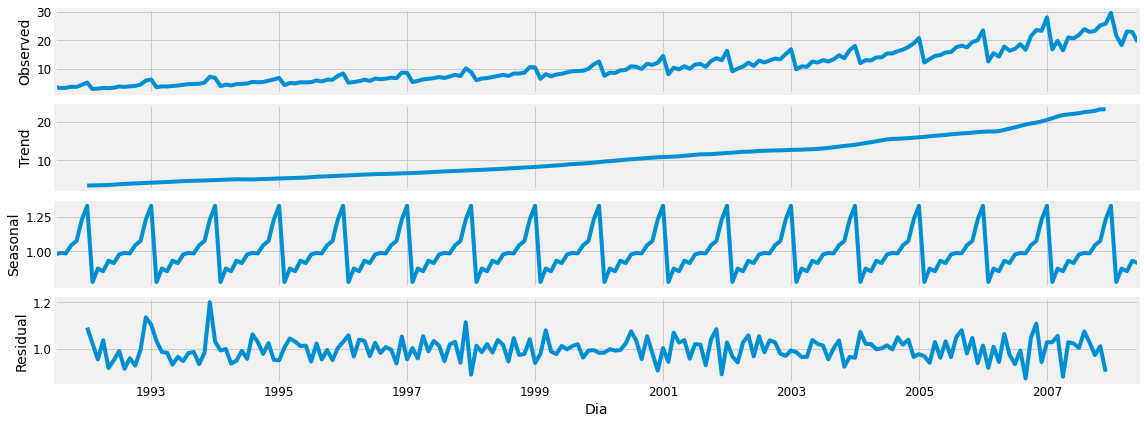

In [11]:
# Decomposição no modelo multiplicativo

resultado_M = seasonal_decompose(df, model='multiplicative')
resultado_M.plot()

Observa-se um padrão muito similar entre os modelos de decomposição aditivo e multiplicativo, pois existe uma grande tendência de crescimento na série. A diferença entre os modelos é maior quando a sazonalidade depende da tendência.

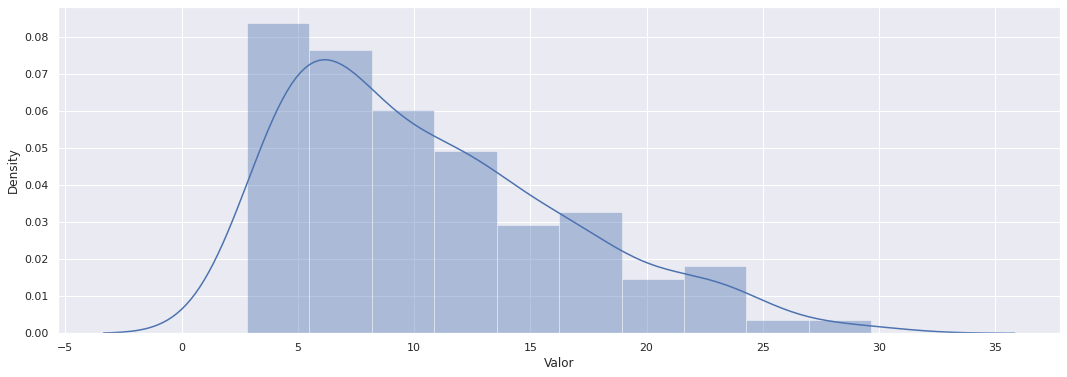

In [12]:
# Gráfico de histograma da representação aproximada da distribuição dos dados numéricos.

sns.set_theme(style="darkgrid")
sns.distplot(df['Valor'].dropna())

Nesse gráfico podemos observar a curva da tendência e a distribuição dos dados. Esses dados são uma média de vendas mensais entre 1991 até 2008, como podemos verificar no modelo de médias móveis logo abaixo:

### Modelo de Médias Móveis

Consiste em utilizar como previsão a média simples das observações mais recentes. Consideraremos a média de k valores consecutivos, podemos tomar a média do último período, ou seja, os últimos 4 valores. O pacote Pandas tem funções específicas definidas para determinar médias móveis como pd.DataFrame.rolling. Iremos executar o código com k=4, e o resultado obtido está ilustrado no gráfico a seguir.

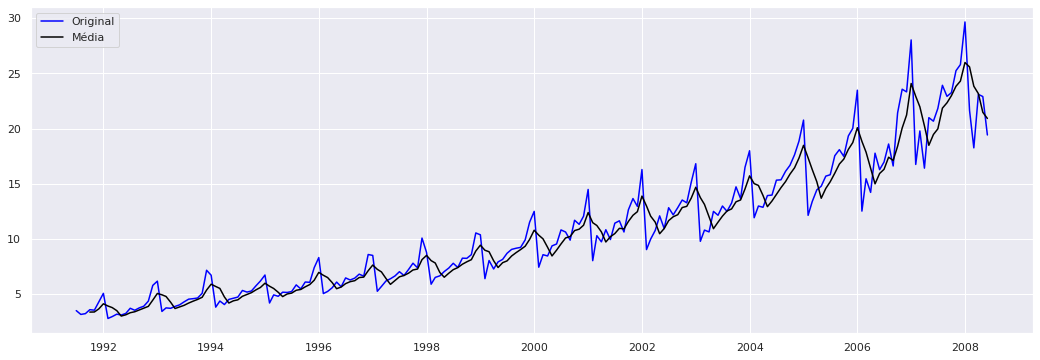

In [13]:
# Modelo de Médias Móveis comparado a série com k=4

dados = df
mm = pd.DataFrame.rolling(dados,window=4,center=False).mean()
orig = plt.plot(dados, color='blue',label='Original')
mean = plt.plot(mm, color='black',label='Média')
plt.legend(loc='best')
plt.show()

Podemos observar uma média bem próxima da original.

Para realizar das previsões de K passos à frente inicialmente utilizaremos o modelo de médias móveis, para previsão de 10 passos à frente. 

In [14]:
def moving_average(series, n):
    '''Calcula a média das últimas n observações'''
    return np.average(series[-n:])

In [15]:
# Previsão 10 passos à frente

moving_average(dados, 10)

23.228633007999996

Logo em seguida iremos verifica o método de amortecimento exponencial.

### Método amortecimento exponencial

Vamos executar o código para Amortecimento Exponencial a seguir:

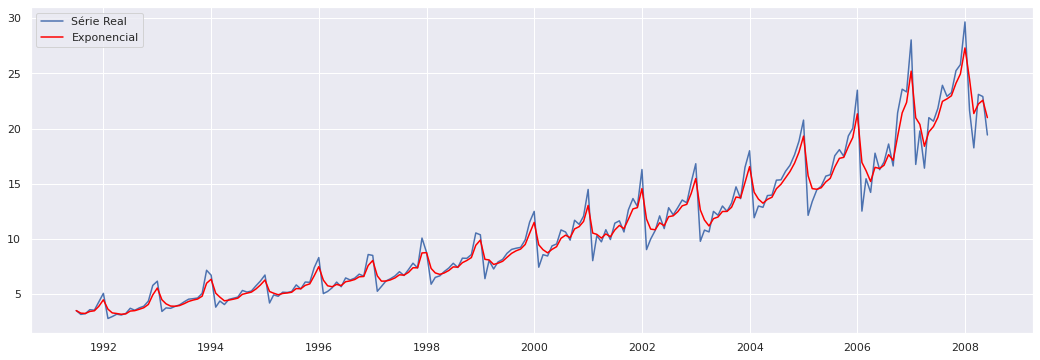

In [16]:
# Amortecimento Exponencial alfa = 0,5

rolling = dados.ewm(alpha=0.5)
rolling_mean = rolling.mean()
plt.plot(dados, label='Série Real')
plt.plot(rolling_mean, color='red', label='Exponencial')
plt.legend(loc='best')
plt.show()

Seguiremos executando o código para Amortecimento Exponencia, exibindo o gráfico comparando os valores da série Real x Exponencial da constante de amortecimento:

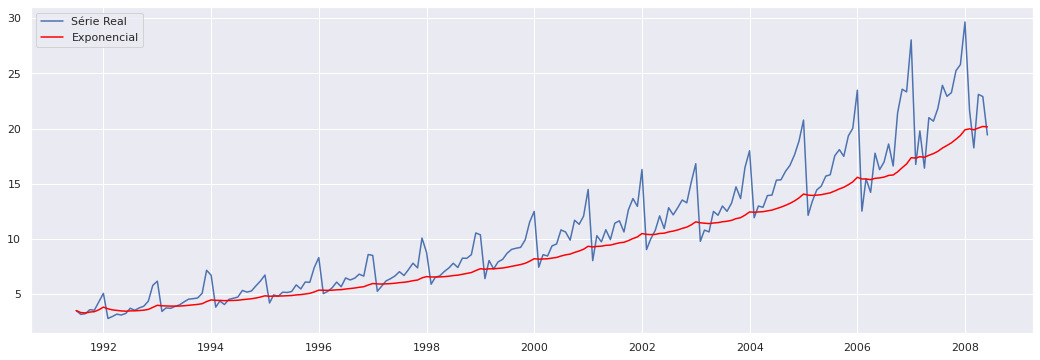

In [17]:
# Amortecimento Exponencial alfa = 0,05

rolling = dados.ewm(alpha=0.05)
rolling_mean = rolling.mean()
plt.plot(dados, label='Série Real')
plt.plot(rolling_mean, color='red', label='Exponencial')
plt.legend(loc='best')
plt.show()

Gráfico comparando mais de um valor da constante de amortecimento:

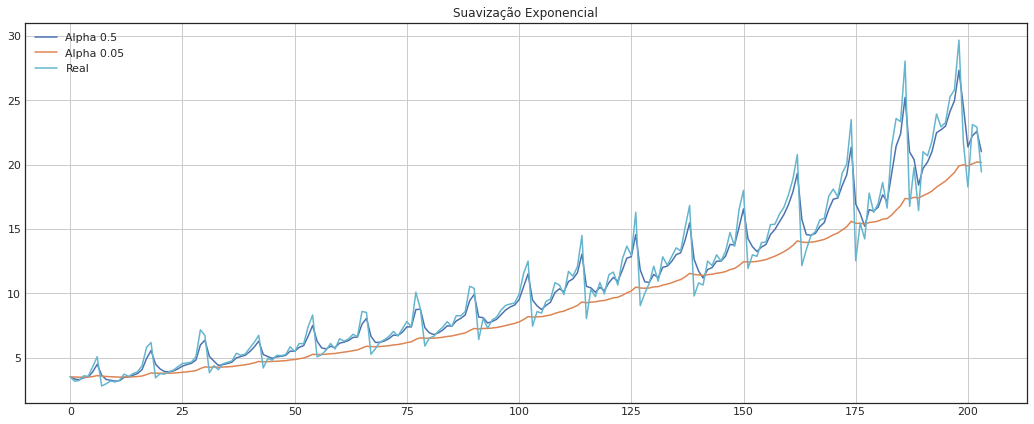

In [18]:
# Função para comparação com duas constantes de amortecimento:

def exponential_smoothing(series, alpha):
    '''
        séries - dataset com o timestamps

        alpha - com float [0.0, 1.0], e o parametro de suavização

    '''
    result = [series[0]] # o primeiro valor é o mesmo que a série
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    '''
        Plota suavização exponencial com diferentes alfas
        
        séries - dataset com o timestamps

        alphas - uma lista com floats, e parametro de suavização
        
    '''
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(16, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))
        plt.plot(series.values, 'c', label = 'Real')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title('Suavização Exponencial')
        plt.grid(True)


plotExponentialSmoothing(dados.Valor, [0.5, 0.05])

Gráfico: Comparação com duas constantes de amortecimento.

### Método de Holt Winters

O método de Holt-Winters compreende a equação de previsão para três equações de suavização.

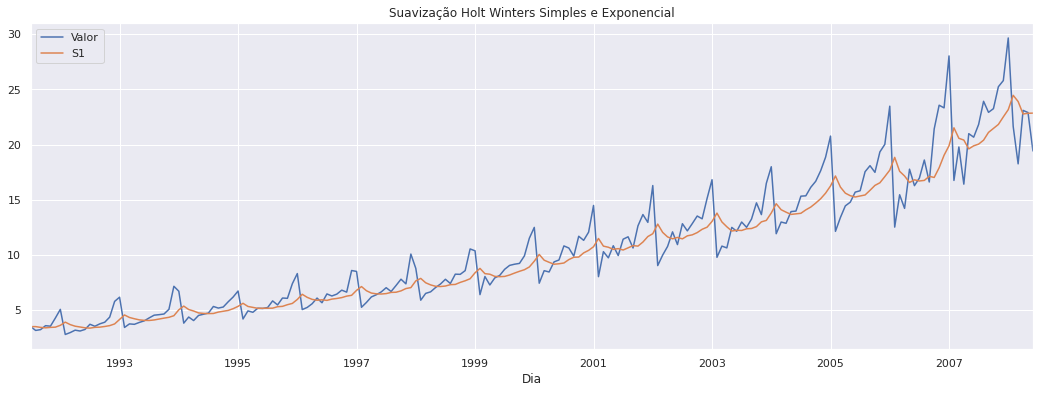

In [16]:
# holt winters (somente com o nível)

# suavização exponencial simples
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# suavização exponencial dupla e tripla
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define o valor de Alpha e defina m (Período de Tempo)
alpha = 0.2
df['S1'] = SimpleExpSmoothing(df['Valor']).fit(smoothing_level=alpha,
                                                  optimized=False,
                                                  use_brute=True).fittedvalues

df[['Valor','S1']].plot(title='Suavização Holt Winters Simples e Exponencial')

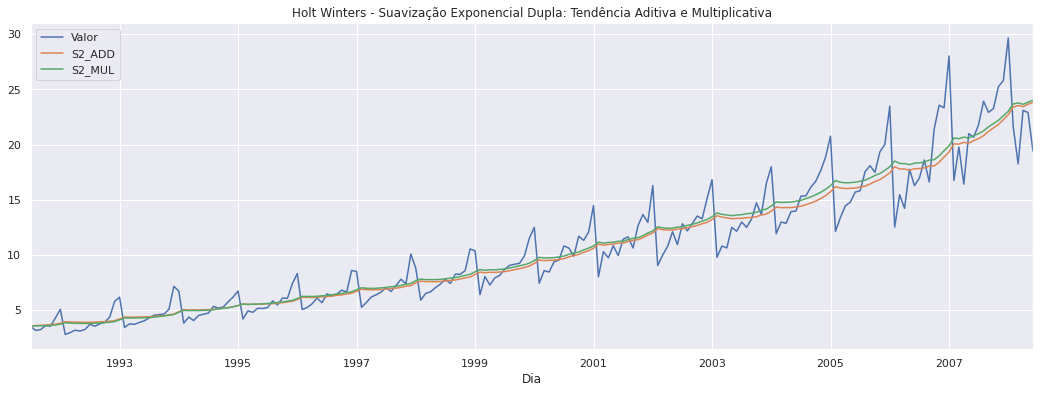

In [17]:
# holt winters (somente com o nível e a tendência aditiva e multiplicativa)

df['S2_ADD'] = ExponentialSmoothing(df['Valor'],trend='add').fit().fittedvalues
df['S2_MUL'] = ExponentialSmoothing(df['Valor'],trend='mul').fit().fittedvalues

df[['Valor','S2_ADD','S2_MUL']].plot(title='Holt Winters - Suavização Exponencial Dupla: Tendência Aditiva e Multiplicativa')

Por último, temos o modelo de Holt-Winters com nível, com a tendência e sazonalidade, tanto para um modelo aditivo quanto multiplicativo:

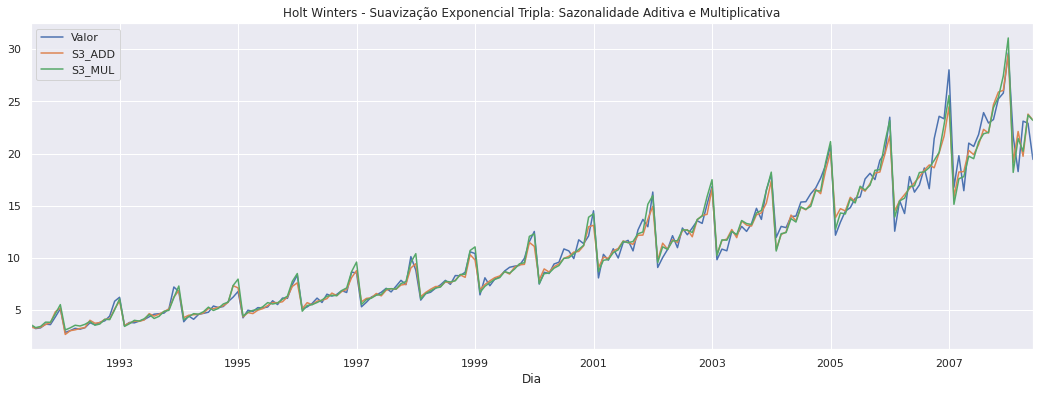

In [18]:
# holt winters (nível, tendência e sazonalidade, aditiva e multiplicativo)

df['S3_ADD'] = ExponentialSmoothing(df['Valor'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df['S3_MUL'] = ExponentialSmoothing(df['Valor'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df[['Valor','S3_ADD','S3_MUL']].plot(title='Holt Winters - Suavização Exponencial Tripla: Sazonalidade Aditiva e Multiplicativa')

Gráfico: Holt-Winters com nível, tendência e sazonalidade para modelo aditivo e modelo multiplicativo.

Vamos fazer a previsão, utilizando o modelo de Holt-Winters. Começaremos dividindo o conjunto de dados em treino e teste. Pegamos 150 dados como conjunto de treino e os últimos 54 últimos pontos de dados como conjunto de teste:

Text(0.5, 1.0, 'Treinamento, Teste e Previsão usando o Holt Winters Aditivo')

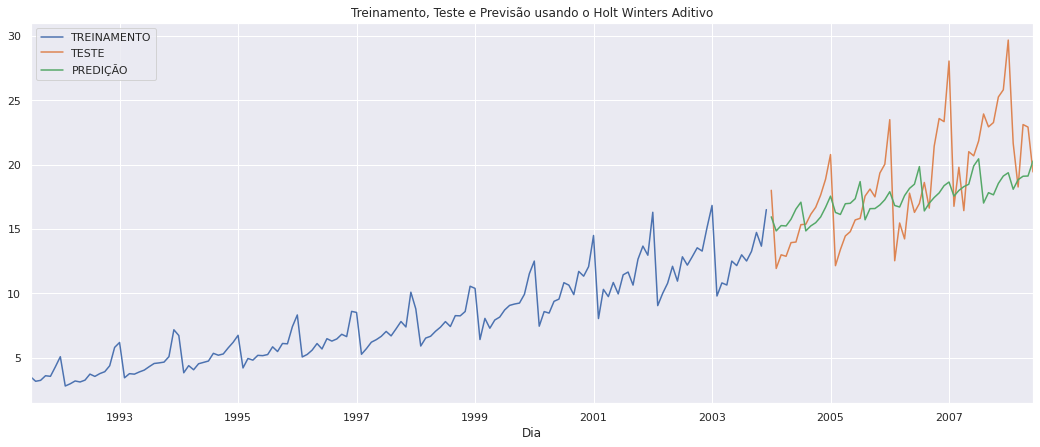

In [19]:
# Previsão 48 passos a frente com modelo de Holt-Winters

# Divisão do teste e treino
train_df = df[:150]
test_df = df[150:]

# Usando o método de suavização exponencial de tendência aditiva
fitted_model = ExponentialSmoothing(train_df['Valor'],trend='add', 
                                    seasonal='add',
                                    seasonal_periods=54).fit()
# modelo de predição
test_predictions = fitted_model.forecast(54)
train_df['Valor'].plot(legend=True,label='TREINAMENTO')
test_df['Valor'].plot(legend=True,label='TESTE',figsize=(16,7))
test_predictions.plot(legend=True,label='PREDIÇÃO')
plt.title('Treinamento, Teste e Previsão usando o Holt Winters Aditivo')

Text(0.5, 1.0, 'Treinamento, Teste e Previsão usando o Holt Winters Multiplicativo')

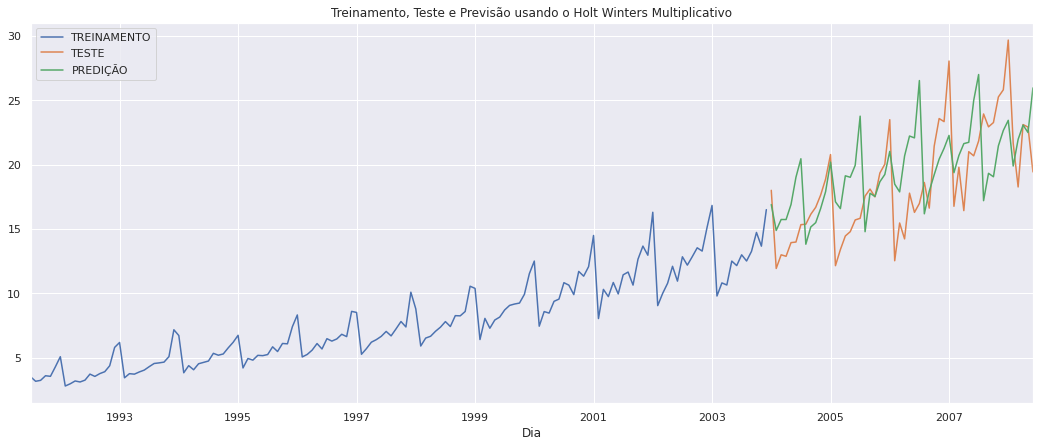

In [20]:
# Usando o método de suavização exponencial de tendência aditiva

fitted_model = ExponentialSmoothing(train_df['Valor'],trend='mul', 
                                    seasonal='mul',
                                    seasonal_periods=54).fit()
# modelo de predição
test_predictions = fitted_model.forecast(54)
train_df['Valor'].plot(legend=True,label='TREINAMENTO')
test_df['Valor'].plot(legend=True,label='TESTE',figsize=(16,7))
test_predictions.plot(legend=True,label='PREDIÇÃO')
plt.title('Treinamento, Teste e Previsão usando o Holt Winters Multiplicativo')

Gráfico: Previsão 54 passos à frente com modelo de Holt-Winters.

In [21]:
# Valores previstos Usando o método de suavização exponencial

test_predictions

2004-01-01    16.898574
2004-02-01    14.888809
2004-03-01    15.738955
2004-04-01    15.735474
2004-05-01    16.904198
2004-06-01    19.022137
2004-07-01    20.454331
2004-08-01    13.819407
2004-09-01    15.156756
2004-10-01    15.494760
2004-11-01    16.588210
2004-12-01    17.893704
2005-01-01    20.191661
2005-02-01    17.111980
2005-03-01    16.583906
2005-04-01    19.129781
2005-05-01    19.016420
2005-06-01    19.946855
2005-07-01    23.759406
2005-08-01    14.790751
2005-09-01    17.776908
2005-10-01    17.526515
2005-11-01    18.667571
2005-12-01    19.235333
2006-01-01    21.025825
2006-02-01    18.482789
2006-03-01    17.881747
2006-04-01    20.669104
2006-05-01    22.217670
2006-06-01    22.074029
2006-07-01    26.522751
2006-08-01    16.180314
2006-09-01    17.933117
2006-10-01    19.213790
2006-11-01    20.421399
2006-12-01    21.264474
2007-01-01    22.265090
2007-02-01    19.372953
2007-03-01    20.704811
2007-04-01    21.627831
2007-05-01    21.730184
2007-06-01    24

Podemos observar que as previsões feitas com o modelo de Holt-Winters se ajustam bem, pois, comparando o período de teste com os valores previstos, vemos que existe o mesmo comportamento na série.

### Modelagem ARIMA 

Utilizaremos a metodologia proposta por Box & Jenkins para a análise da série temporal. A identificação anterior não pretende definir o modelo final para representar a série. Se assim fosse, não haveria necessidade das outras etapas de modelagem. Como já vimos, o objetivo é apenas definir os valores de p, d e q que, inicialmente, sejam adequados para modelar a série, segundo os autores do método, esse diagnóstico costuma conduzir a um modelo subespecificado, menor do que o modelo verdadeiro para a série.

Iremos fazer os gráficos da função de autocorrelação (FAC) e função de autocorrelação parcial (FAC) para confirmar se a série é não estacionária.

In [22]:
# Exibindo os principais dados

df.head()

,Valor,S1,S2_ADD,S2_MUL,S3_ADD,S3_MUL
Dia,,,,,,
1991-07-01,3.526591,3.526591,3.571602,3.559350,3.321492,3.580454
1991-08-01,3.180891,3.526591,3.620558,3.591079,3.229195,3.273335
1991-09-01,3.252221,3.457451,3.642830,3.598357,3.306907,3.386941
1991-10-01,3.611003,3.416405,3.666643,3.609606,3.570339,3.800287
1991-11-01,3.565869,3.455325,3.711392,3.643481,3.751898,3.787340


In [23]:
df_novo = df.drop(columns=['S1','S2_ADD','S2_MUL','S3_ADD','S3_MUL'])

df_novo.head()

,Valor
Dia,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


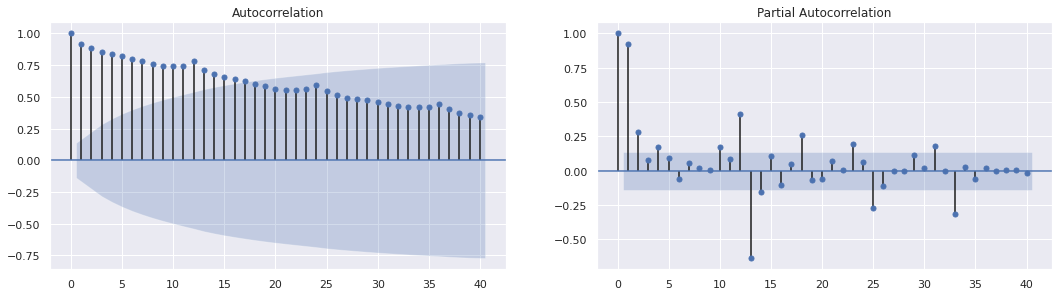

In [24]:
# Função de autocorrelação (FAC) e função de autocorrelação parcial (FAC)

def acf_pacf(x):
  
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=40, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=40, ax=ax2)

acf_pacf(df_novo)

Observa-se que a FAC (Função de Autocorrelação) decai lentamente como senoides amortecidos e a FACP (Função de Autocorrelação Parcial) possui o lag 1 significativo, ou seja, truncada no lag 1, o que sugere um modelo de médias móveis de ordem 1.

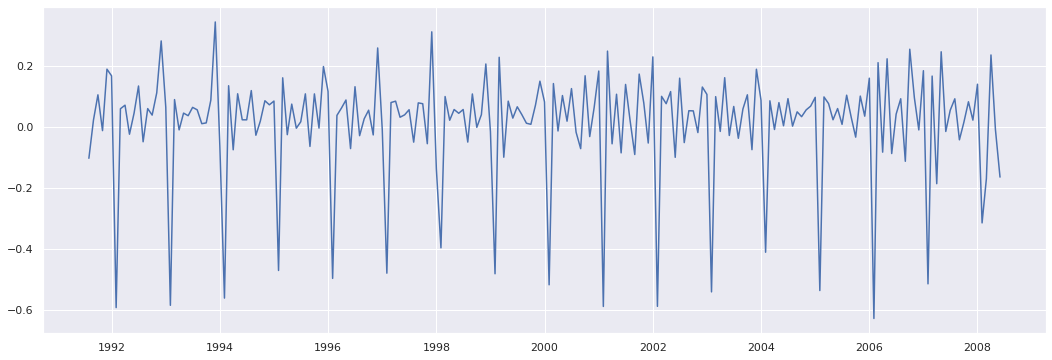

In [25]:
# Transformar a série em uma série estacionária

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.plot(np.log(df_novo).diff().dropna())

Dessa maneira, o procedimento sugerido por Box & Jenkins para a identificação das ordens p e q de um modelo de séries temporais é, a partir da série que se quer analisar, estimar a FAC obtendo o gráfico da FAC e da FACP amostral.

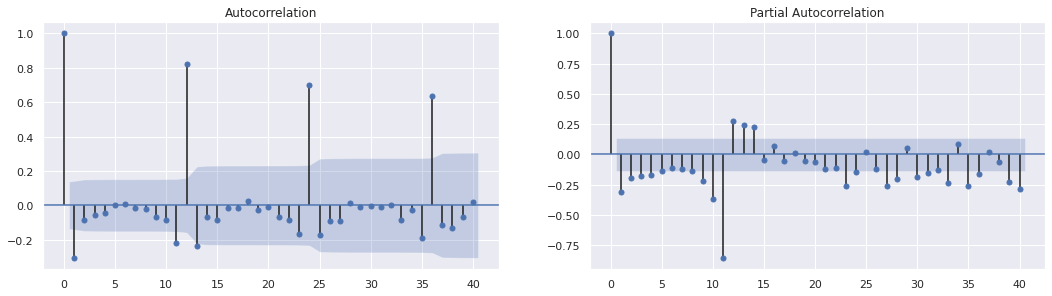

In [26]:
# FAC e FACP para série estacionária

acf_pacf(np.log(df_novo).diff().dropna())

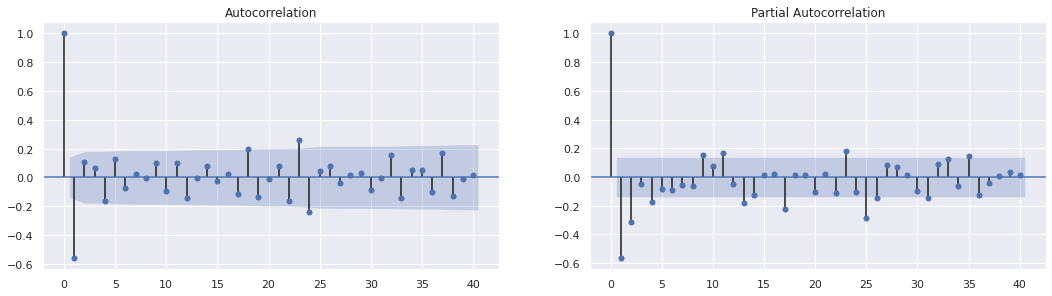

In [27]:
# FAC e FACP para série estacionária

acf_pacf(np.log(df_novo).diff().diff(12).dropna())

Gráfico: FAC e FACP para série estacionária.

A série transformada, após uma diferença, ou seja, foi identificado que d=1 esendo aplicada à função logarítmica que ficou não estacionária. E como a condição para estimar o modelo ARIMA é que a série seja estacionária, podemos seguir com a análise:

Observamos que, mesmo após a diferença, a série apresenta os pontos fora do intervalo de confiança; esses pontos estão ocorrendo a cada lag múltiplo de 12, o que caracteriza que necessita de diferença sazonais.

Estimaremos um modelo ARIMA(p,d,q) conforme enunciado do Exercício 04, para prever 10 valores posteriores a n, e em seguida exibir um gráfico Real x Estimado.

Primeiro dividiremos os dados para teste e treinamento:

In [28]:
# Dividindo os dados para treinamento e teste

df_treinamento, dados_teste = df_novo[0:int(len(df_novo)*0.7)], df_novo[int(len(df_novo)*0.7):]
df_treinamento = df_treinamento['Valor'].values
dados_teste = dados_teste['Valor'].values
df_historico = [x for x in df_treinamento]
modelo_pred = []

In [29]:
obs_teste = len(dados_teste)

for p_teste in range(obs_teste ):
  modelo = ARIMA(df_historico, order=(1,1,1))
  modelo_fit = modelo.fit(disp=0)
  saida = modelo_fit.forecast()
  yt = saida[0]
  modelo_pred.append(yt)
  valor_R_teste = dados_teste[p_teste]
  df_historico.append(valor_R_teste)

In [30]:
# Visualização do modelo

print(modelo_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  202
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -414.635
Method:                       css-mle   S.D. of innovations              1.879
Date:                Fri, 04 Feb 2022   AIC                            837.269
Time:                        20:58:52   BIC                            850.502
Sample:                             1   HQIC                           842.624
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0990      0.018      5.496      0.000       0.064       0.134
ar.L1.D.y      0.3068      0.075      4.111      0.000       0.161       0.453
ma.L1.D.y     -0.9103      0.027    -33.642      0.0

In [31]:
# Geração validação pelo erro quadrático médio

erroMSE = mean_squared_error(dados_teste, modelo_pred)
print(f'O Erro Médio Quadrático (MSE) é {erroMSE}')

O Erro Médio Quadrático (MSE) é 8.531107051753217


Em estatística, o erro quadrático médio ou desvio quadrático médio de um estimador mede a média dos quadrados dos erros, ou seja, a diferença quadrática média entre os valores estimados e o valor real.

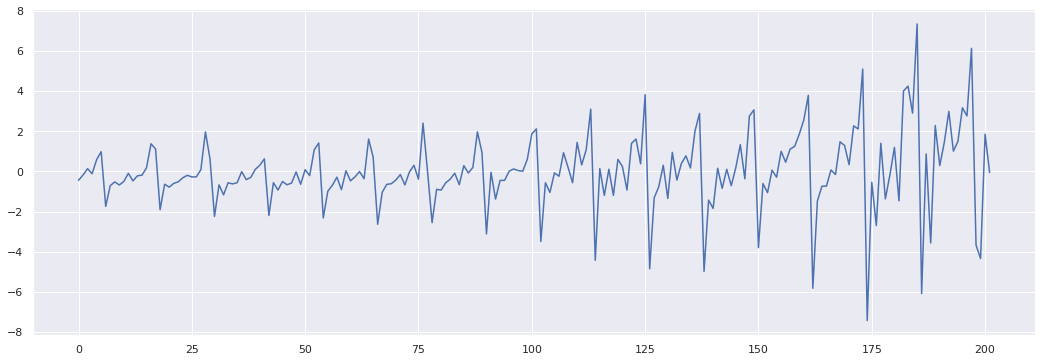

In [32]:
# Gráfico dos resíduos

grafico_resid = modelo_fit.resid
orig = plt.plot(grafico_resid)
plt.show()

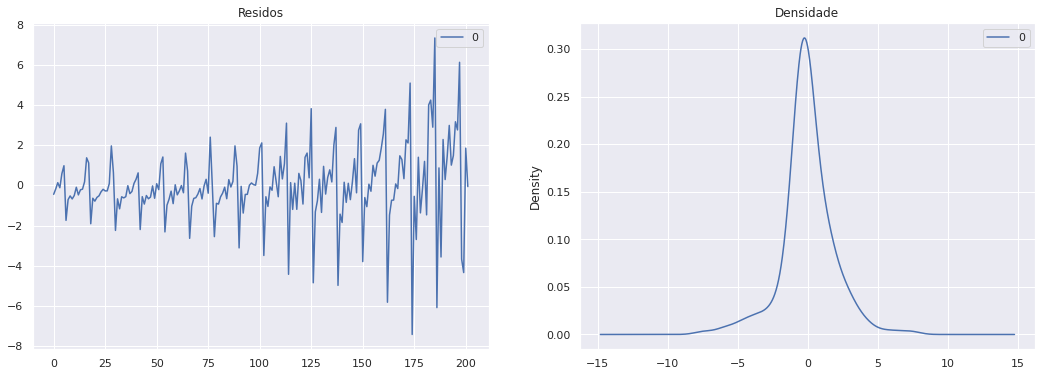

In [33]:
residuals = pd.DataFrame(grafico_resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residos", ax=ax[0])
residuals.plot(kind='kde', title='Densidade', ax=ax[1])
plt.show()

Gráfico: Resíduos.

Os resíduos são estacionários, possuem a média zero; agora, vamos fazer a FAC e FACP para verificar autocorrelação dos resíduos:

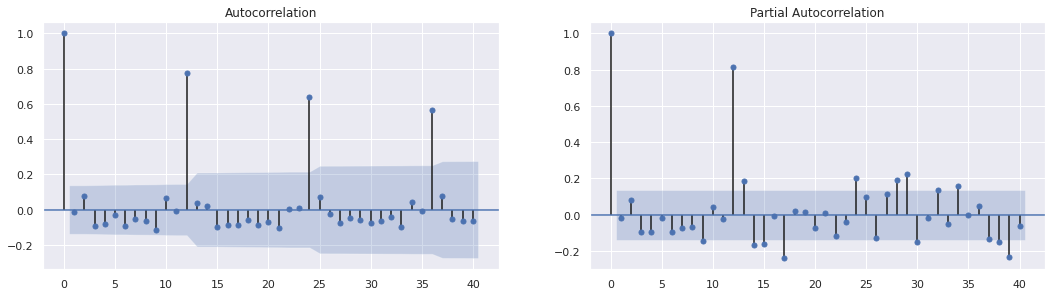

In [34]:
# FAC e FACP dos resíduos
acf_pacf(grafico_resid)

Podemos observar que não há indícios de autocorrelação dos resíduos, as FAC e FACP estão dentro do intervalo de confiança.

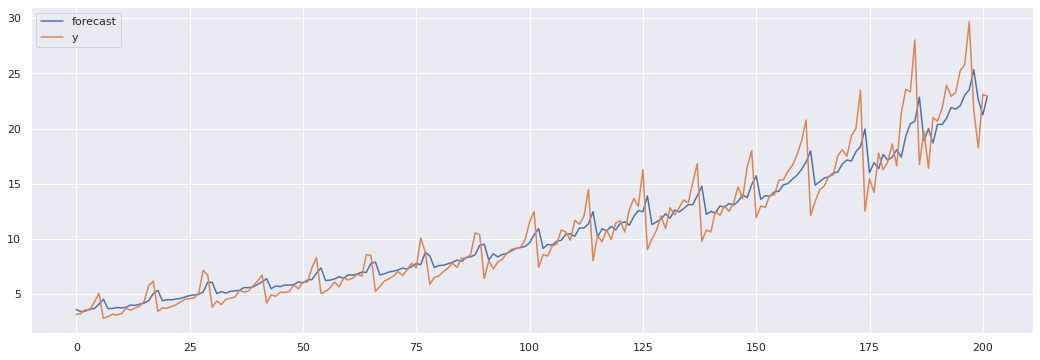

In [35]:
# Vamos verificar a previsão e também a precisão do modelo 1, 1, 1

modelo_fit.plot_predict(dynamic=False)
plt.show()

Observando o gráfico podemos verificar que a predição não se encaixa muito bem aos dados.

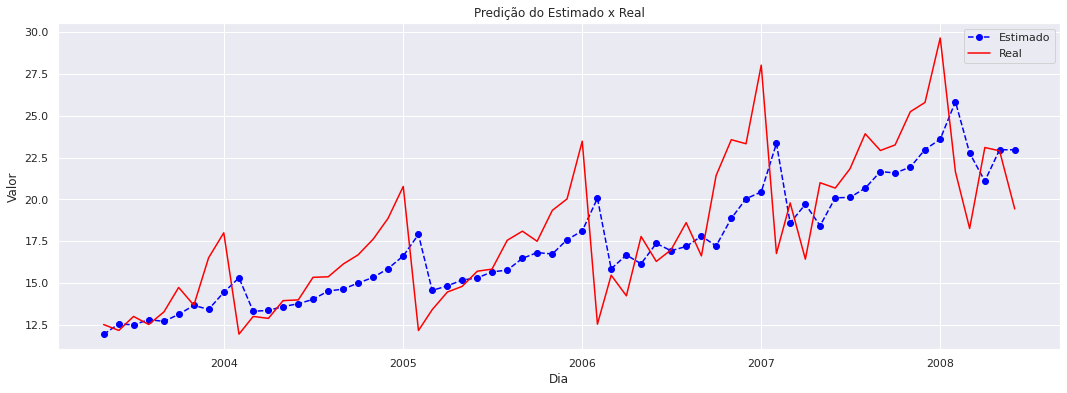

In [36]:
novo_teste = df_novo[int(len(df_novo)*0.7):].index
# novo_teste = modelo_fit.

plt.plot(novo_teste, 
         modelo_pred, 
         color='blue',
         marker='o',
         linestyle='dashed',
         label='Estimado')

plt.plot(novo_teste, 
         dados_teste, 
         color='red', 
         label='Real')

plt.title('Predição do Estimado x Real')
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.legend()
plt.show()

Gráficos: Previsão - Real x Estimado.

### Segunda validação do modelo ARIMA

Verificamos anteriormente que o modelo ARIMA(1, 1, 1) não obteve um bom desempenho na predição, portanto iremos rodar o modelo em uma nova ordem (1, 1, 0) e observar o seu desempenho.

In [37]:
# Dividindo os dados para treinamento e teste

df_treinamento, dados_teste = df_novo[0:int(len(df_novo)*0.7)], df_novo[int(len(df_novo)*0.7):]
df_treinamento = df_treinamento['Valor'].values
dados_teste = dados_teste['Valor'].values
df_historico = [x for x in df_treinamento]
modelo_pred = []

In [38]:
obs_teste = len(dados_teste)

for p_teste in range(obs_teste ):
  modelo = ARIMA(df_historico, order=(1,1,0)) # alteração na ordem do modelo
  modelo_fit = modelo.fit(disp=0)
  saida = modelo_fit.forecast()
  yt = saida[0]
  modelo_pred.append(yt)
  valor_R_teste = dados_teste[p_teste]
  df_historico.append(valor_R_teste)

In [39]:
# Visualização do modelo

print(modelo_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  202
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -433.574
Method:                       css-mle   S.D. of innovations              2.069
Date:                Fri, 04 Feb 2022   AIC                            873.149
Time:                        21:00:34   BIC                            883.074
Sample:                             1   HQIC                           877.164
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0970      0.106      0.911      0.364      -0.112       0.306
ar.L1.D.y     -0.3691      0.065     -5.666      0.000      -0.497      -0.241
                                    Roots           

In [40]:
# Geração validação pelo erro quadrático médio

erroMSE = mean_squared_error(dados_teste, modelo_pred)
print(f'O Erro Médio Quadrático (MSE) é {erroMSE}')

O Erro Médio Quadrático (MSE) é 9.50083432688545


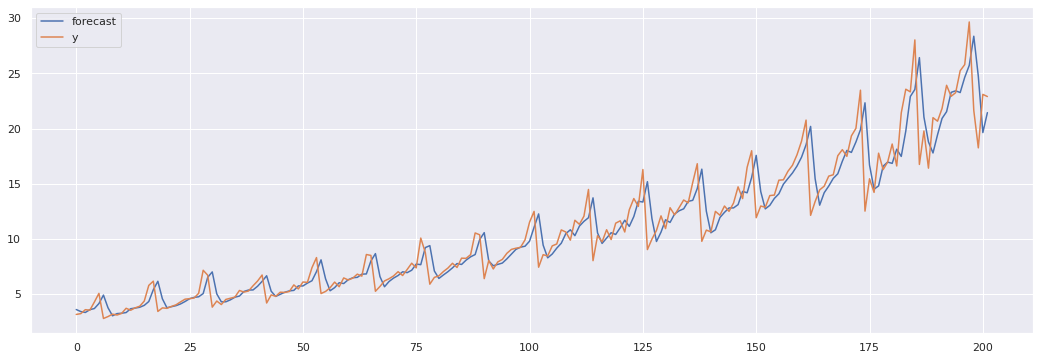

In [41]:
# Vamos verificar a previsão e também a precisão do modelo 1, 1, 0

modelo_fit.plot_predict(dynamic=False)
plt.show()

No gráfico acima podemos observar que previsão se aproxima mais dos dados, demonstrando um melhor desempenho para o modelo 1, 1, 0.

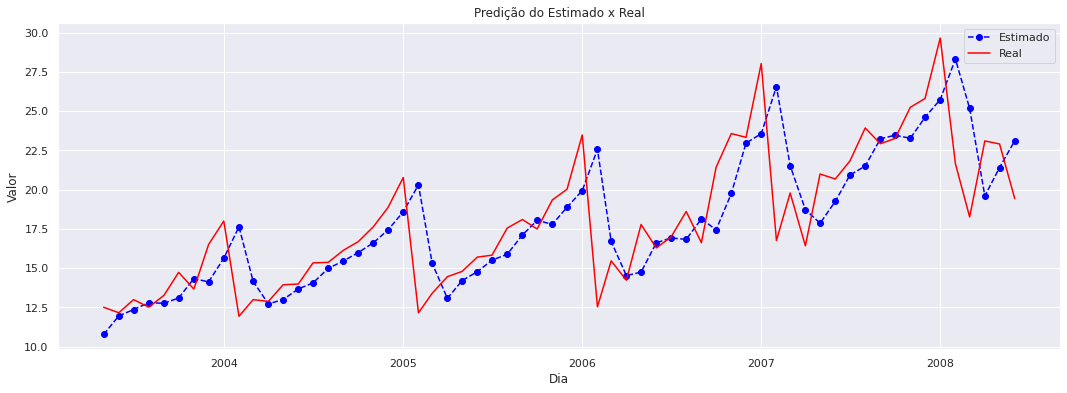

In [42]:
novo_teste = df_novo[int(len(df_novo)*0.7):].index
# novo_teste = modelo_fit.

plt.plot(novo_teste, 
         modelo_pred, 
         color='blue',
         marker='o',
         linestyle='dashed',
         label='Estimado')

plt.plot(novo_teste, 
         dados_teste, 
         color='red', 
         label='Real')

plt.title('Predição do Estimado x Real')
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.legend()
plt.show()

Os resultados são satisfatórios, é um otímo exemplo para ter uma ideia de como o ARIMA funciona. Vamos fazer uma verificação rápida da métrica de precisão no mesmo para ver o quão bem o modelo pode prever o valor futuro.

In [52]:
# Modelo ARIMA 2 para conparação de precisão

modelo = sm.tsa.ARIMA(df_historico, order=(1, 1, 0))  
fitted = modelo.fit(disp=0)

# Previsão
fc, se, conf = fitted.forecast(1, alpha=0.05)

# MAPE - Mean Absolute Percentage Error
mape = np.mean(np.abs(fc - df_historico)/np.abs(df_historico))

print(f'Valor previsto:{fc}')

Valor previsto:[20.82711801]


O valor previsto pelo modelo final ARIMA foi 20.82711801.

In [53]:
mape

1.6923026252475601

O MAPE é de 1.6923026252475601, ou seja, a precisão do modelo é de 98,30%. O Mean Absolute Percentage Error (MAPE) - erro percentual médio absoluto é um dos KPIs mais usados para medir a precisão da previsão.